# Assignment 3: Question Answering

Welcome to this week's assignment of course 4. In this you will explore question answering. You will implement the "Text to Text Transfer from Transformers" (better known as T5). Since you implemented transformers from scratch last week you will now be able to use them. 

<img src = "images/qa.png"> 

## Outline

- [Overview](#0)
- [Part 0: Importing the Packages](#0)
- [Part 1: C4 Dataset](#1)
    - [1.1 Pre-Training Objective](#1.1)
    - [1.2 Process C4](#1.2)
        - [1.2.1 Decode to natural language](#1.2.1)
    - [1.3 Tokenizing and Masking](#1.3)
        - [Exercise 01](#ex01)
    - [1.4 Creating the Pairs](#1.4)
- [Part 2: Transfomer](#2)
    - [2.1 Transformer Encoder](#2.1)
        - [2.1.1 The Feedforward Block](#2.1.1)
            - [Exercise 02](#ex02)
        - [2.1.2 The Encoder Block](#2.1.2)
            - [Exercise 03](#ex03)
        - [2.1.3 The Transformer Encoder](#2.1.3)            
            - [Exercise 04](#ex04)

<a name='0'></a>
### Overview

This assignment will be different from the two previous ones. Due to memory and time constraints of this environment you will not be able to train a model and use it for inference. Instead you will create the necessary building blocks for the transformer encoder model and will use a pretrained version of the same model in two ungraded labs after this assignment.

After completing these 3 (1 graded and 2 ungraded) labs you will:
* Implement the code neccesary for Bidirectional Encoder Representation from Transformer (BERT).
* Understand how the C4 dataset is structured.
* Use a pretrained model for inference.
* Understand how the "Text to Text Transfer from Transformers" or T5 model works. 

<a name='0'></a>
# Part 0: Importing the Packages

In [1]:
import ast
import pprint
import string
import textwrap
import itertools
import numpy as np
import w3_tests

import trax 
from trax import layers as tl
from trax.supervised import decoding

# Will come handy later.
wrapper = textwrap.TextWrapper(width=70)

# Set random seed
np.random.seed(42)

<a name='1'></a>
## Part 1: C4 Dataset

The [C4](https://www.tensorflow.org/datasets/catalog/c4) is a huge data set. For the purpose of this assignment you will use a few examples out of it which are present in `data.txt`. C4 is based on the [common crawl](https://commoncrawl.org/) project. Feel free to read more on their website. 

Run the cell below to see how the examples look like. 

In [2]:
# load example jsons
example_jsons = list(map(ast.literal_eval, open('data/data.txt')))

In [3]:
# Printing the examples to see how the data looks like
for i in range(5):
    print(f'example number {i+1}: \n\n{example_jsons[i]} \n')

example number 1: 

{'content-length': b'1970', 'content-type': b'text/plain', 'text': b'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': b'2019-04-25T12:57:54Z', 'url': b'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'} 

example number 2: 

{'content-length': b'120

Notice the `b` before each string? This means that this data comes as bytes rather than strings. Strings are actually lists of bytes so for the rest of the assignments the name `strings` will be used to describe the data. 

To check this run the following cell:

In [4]:
type(example_jsons[0].get('text'))

bytes

<a name='1.1'></a>
###  1.1 Pre-Training Objective

**Note:** The word "mask" will be used throughout this assignment in context of hiding/removing word(s)

You will be implementing the BERT loss as shown in the following image. 

<img src = "images/loss.png" width="600" height = "400">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>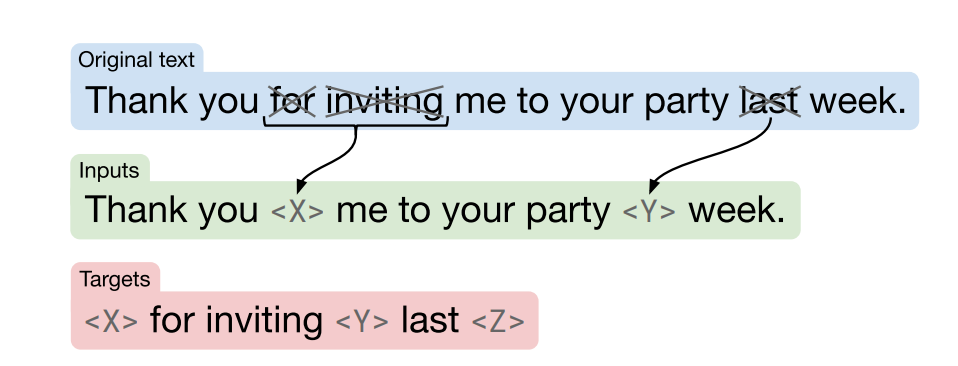</body></html>

Assume you have the following text: <span style = "color:blue"> **Thank you <span style = "color:red">for inviting </span> me to your party <span style = "color:red">last</span>  week** </span> 


Now as input you will mask the words in red in the text: 

<span style = "color:blue"> **Input:**</span> Thank you  **X** me to your party **Y** week.

<span style = "color:blue">**Output:**</span> The model should predict the words(s) for **X** and **Y**. 

**Z** is used to represent the end.

<a name='1.2'></a>
### 1.2 Process C4

C4 only has the plain string `text` field, so you will tokenize and have `inputs` and `targets` out of it for supervised learning. Given your inputs, the goal is to predict the targets during training. 

You will now take the `text` and convert it to `inputs` and `targets`.

In [5]:
# Grab text field from dictionary
natural_language_texts = [example_json['text'] for example_json in example_jsons]

In [6]:
# First text example
natural_language_texts[4]

b'The Denver Board of Education opened the 2017-18 school year with an update on projects that include new construction, upgrades, heat mitigation and quality learning environments.\nWe are excited that Denver students will be the beneficiaries of a four year, $572 million General Obligation Bond. Since the passage of the bond, our construction team has worked to schedule the projects over the four-year term of the bond.\nDenver voters on Tuesday approved bond and mill funding measures for students in Denver Public Schools, agreeing to invest $572 million in bond funding to build and improve schools and $56.6 million in operating dollars to support proven initiatives, such as early literacy.\nDenver voters say yes to bond and mill levy funding support for DPS students and schools. Click to learn more about the details of the voter-approved bond measure.\nDenver voters on Nov. 8 approved bond and mill funding measures for DPS students and schools. Learn more about what\xe2\x80\x99s incl

<a name='1.2.1'></a>
#### 1.2.1 Decode to natural language

The following functions will help you `detokenize` and`tokenize` the text data.  

The `sentencepiece` vocabulary was used to convert from text to ids. This vocabulary file is loaded and used in these helper functions.

`natural_language_texts` has the text from the examples we gave you. 

Run the cells below to see what is going on. 

In [7]:
# Special tokens
PAD, EOS, UNK = 0, 1, 2

def detokenize(np_array):
    return trax.data.detokenize(
        np_array,
        vocab_type='sentencepiece',
        vocab_file='sentencepiece.model',
        vocab_dir='./models')

def tokenize(s):
  # The trax.data.tokenize function operates on streams,
  # that's why we have to create 1-element stream with iter
  # and later retrieve the result with next.
    return next(trax.data.tokenize(
        iter([s]),
        vocab_type='sentencepiece',
        vocab_file='sentencepiece.model',
        vocab_dir='./models'))

In [8]:
# printing the encoding of each word to see how subwords are tokenized
tokenized_text = [(tokenize(word).tolist(), word) for word in natural_language_texts[0].split()]
print(tokenized_text, '\n')

[([12847, 277], b'Beginners'), ([15068], b'BBQ'), ([4501], b'Class'), ([3, 12297], b'Taking'), ([3399], b'Place'), ([16], b'in'), ([5964, 7115, 9, 55], b'Missoula!'), ([531], b'Do'), ([25], b'you'), ([241], b'want'), ([12], b'to'), ([129], b'get'), ([394], b'better'), ([44], b'at'), ([492], b'making'), ([3326], b'delicious'), ([15068, 58], b'BBQ?'), ([148], b'You'), ([56], b'will'), ([43], b'have'), ([8], b'the'), ([1004, 6], b'opportunity,'), ([474], b'put'), ([48], b'this'), ([30], b'on'), ([39], b'your'), ([4793], b'calendar'), ([230, 5], b'now.'), ([2721, 6], b'Thursday,'), ([1600], b'September'), ([1630, 727], b'22nd'), ([1715], b'join'), ([1150], b'World'), ([4501], b'Class'), ([15068], b'BBQ'), ([16127, 6], b'Champion,'), ([9137], b'Tony'), ([2659, 5595], b'Balay'), ([45], b'from'), ([301, 782, 3624], b'Lonestar'), ([14627, 15], b'Smoke'), ([12612, 277, 5], b'Rangers.'), ([216], b'He'), ([56], b'will'), ([36], b'be'), ([2119], b'teaching'), ([3, 9], b'a'), ([19529], b'beginner')

In [9]:
# We can see that detokenize successfully undoes the tokenization
print(f"tokenized: {tokenize('Beginners')}\ndetokenized: {detokenize(tokenize('Beginners'))}")

tokenized: [12847   277]
detokenized: Beginners


As you can see above, you were able to take a piece of string and tokenize it. 

Now you will create `input` and `target` pairs that will allow you to train your model. T5 uses the ids at the end of the vocab file as sentinels. For example, it will replace: 
   - `vocab_size - 1` by `<Z>`
   - `vocab_size - 2` by `<Y>`
   - and so forth. 
   
It assigns every word a `chr`.

The `pretty_decode` function below, which you will use in a bit, helps in handling the type when decoding. Take a look and try to understand what the function is doing.


Notice that:
```python
string.ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
```

**NOTE:** Targets may have more than the 52 sentinels we replace, but this is just to give you an idea of things.

In [10]:
vocab_size = trax.data.vocab_size(
    vocab_type='sentencepiece',
    vocab_file='sentencepiece.model',
    vocab_dir='./models')

def get_sentinels(vocab_size=32000, display=False):
    sentinels = {}
    for i, char in enumerate(reversed(string.ascii_letters), 1):
        decoded_text = detokenize([vocab_size - i]) 
        
        # Sentinels, ex: <Z> - <a>
        sentinels[decoded_text] = f'<{char}>'    
    
        if display:
            print(f'The sentinel is <{char}> and the decoded token is:', decoded_text)

    return sentinels

In [11]:
sentinels = get_sentinels(vocab_size, display=True)

The sentinel is <Z> and the decoded token is: Internațional
The sentinel is <Y> and the decoded token is: erwachsene
The sentinel is <X> and the decoded token is: Cushion
The sentinel is <W> and the decoded token is: imunitar
The sentinel is <V> and the decoded token is: Intellectual
The sentinel is <U> and the decoded token is: traditi
The sentinel is <T> and the decoded token is: disguise
The sentinel is <S> and the decoded token is: exerce
The sentinel is <R> and the decoded token is: nourishe
The sentinel is <Q> and the decoded token is: predominant
The sentinel is <P> and the decoded token is: amitié
The sentinel is <O> and the decoded token is: erkennt
The sentinel is <N> and the decoded token is: dimension
The sentinel is <M> and the decoded token is: inférieur
The sentinel is <L> and the decoded token is: refugi
The sentinel is <K> and the decoded token is: cheddar
The sentinel is <J> and the decoded token is: unterlieg
The sentinel is <I> and the decoded token is: garanteaz
Th

In [12]:
def pretty_decode(encoded_str_list, sentinels):
    # If already a string, just do the replacements.
    if isinstance(encoded_str_list, (str, bytes)):
        for token, char in sentinels.items():
            encoded_str_list = encoded_str_list.replace(token, char)
        return encoded_str_list
  
    # We need to decode and then prettyfy it.
    return pretty_decode(detokenize(encoded_str_list), sentinels)

In [13]:
pretty_decode("I want to dress up as an Intellectual this halloween.", sentinels)

'I want to dress up as an <V> this <b>.'

The functions above make your `inputs` and `targets` more readable. For example, you might see something like this once you implement the masking function below. 

- <span style="color:red"> Input sentence: </span> Younes and Lukasz were working together in the lab yesterday after lunch. 
- <span style="color:red">Input: </span> Younes and Lukasz  **Z** together in the **Y** yesterday after lunch.
- <span style="color:red">Target: </span> **Z** were working **Y** lab.


<a name='1.3'></a>
### 1.3 Tokenizing and Masking

You will now implement the `tokenize_and_mask` function. This function  will allow you to tokenize and mask input words with a noise probability. We usually mask 15% of the words.

<a name='ex01'></a>
### Exercise 01

In [14]:
# GRADED FUNCTION: tokenize_and_mask
def tokenize_and_mask(text, vocab_size=32000, noise=0.15, 
                      randomizer=np.random.uniform, tokenize=tokenize):
    """Tokenizes and masks a given input.

    Args:
        text (str or bytes): Text input.
        vocab_size (int, optional): Size of the vocabulary. Defaults to vocab_size.
        noise (float, optional): Probability of masking a token. Defaults to 0.15.
        randomizer (function, optional): Function that generates random values. Defaults to np.random.uniform.
        tokenize (function, optional): Tokenizer function. Defaults to tokenize.

    Returns:
        tuple: Tuple of lists of integers associated to inputs and targets.
    """
    
    # current sentinel number (starts at 0)
    cur_sentinel_num = 0
    # inputs
    inps = []
    # targets
    targs = []
    
    ### START CODE HERE ###
    
    # prev_no_mask is True if the previous token was NOT masked, False otherwise
    # set prev_no_mask to True
    prev_no_mask = True
    
    # loop through tokenized `text`
    for token in tokenize(text):
        # check if the `noise` is greater than a random value (weighted coin flip)
        if randomizer() < noise:
            # check to see if the previous token was not masked
            if prev_no_mask==True: # add new masked token at end_id
                # number of masked tokens increases by 1
                cur_sentinel_num += 1
                # compute `end_id` by subtracting current sentinel value out of the total vocabulary size
                end_id = vocab_size - cur_sentinel_num
                # append `end_id` at the end of the targets
                targs.append(end_id)
                # append `end_id` at the end of the inputs
                inps.append(end_id)
            # append `token` at the end of the targets
            targs.append(token)
            # set prev_no_mask accordingly
            prev_no_mask = False
        
        else: # don't have two masked tokens in a row
            # append `token ` at the end of the inputs
            inps.append(token)
            # set prev_no_mask accordingly
            prev_no_mask = True
            
    ### END CODE HERE ###
    
    return inps, targs

In [15]:
# Some logic to mock a np.random value generator
# Needs to be in the same cell for it to always generate same output
def testing_rnd():
    def dummy_generator():
        vals = np.linspace(0, 1, 10)
        cyclic_vals = itertools.cycle(vals)
        for _ in range(100):
            yield next(cyclic_vals)

    dumr = itertools.cycle(dummy_generator())

    def dummy_randomizer():
        return next(dumr)
    
    return dummy_randomizer

input_str = natural_language_texts[0]
print(f"input string:\n\n{input_str}\n")
inps, targs = tokenize_and_mask(input_str, randomizer=testing_rnd())
print(f"tokenized inputs:\n\n{inps}\n")
print(f"targets:\n\n{targs}")

input string:

b'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.'

tokenized inputs:

[31999, 15068, 4501, 3, 12297, 3399, 16, 5964, 7115, 31998, 531, 25, 241, 12, 129, 394, 44, 492, 31997, 58, 148, 56, 43, 8, 1004, 6, 474, 31996, 39, 4793, 230, 5, 2721, 6, 1600, 1630, 31995, 1150, 4501, 15068, 1

#### **Expected Output:**
```CPP
b'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.'

tokenized inputs:

[31999, 15068, 4501, 3, 12297, 3399, 16, 5964, 7115, 31998, 531, 25, 241, 12, 129, 394, 44, 492, 31997, 58, 148, 56, 43, 8, 1004, 6, 474, 31996, 39, 4793, 230, 5, 2721, 6, 1600, 1630, 31995, 1150, 4501, 15068, 16127, 6, 9137, 2659, 5595, 31994, 782, 3624, 14627, 15, 12612, 277, 5, 216, 31993, 2119, 3, 9, 19529, 593, 853, 21, 921, 31992, 12, 129, 394, 28, 70, 17712, 1098, 5, 31991, 3884, 25, 762, 25, 174, 12, 214, 12, 31990, 3, 9, 3, 23405, 4547, 15068, 2259, 6, 31989, 6, 5459, 6, 13618, 7, 6, 3604, 1801, 31988, 6, 303, 24190, 11, 1472, 251, 5, 37, 31987, 36, 16, 8, 853, 19, 25264, 399, 568, 31986, 21, 21380, 7, 34, 19, 339, 5, 15746, 31985, 8, 583, 56, 36, 893, 3, 9, 3, 31984, 9486, 42, 3, 9, 1409, 29, 11, 25, 31983, 12246, 5977, 13, 284, 3604, 24, 19, 2657, 31982]

targets:

[31999, 12847, 277, 31998, 9, 55, 31997, 3326, 15068, 31996, 48, 30, 31995, 727, 1715, 31994, 45, 301, 31993, 56, 36, 31992, 113, 2746, 31991, 216, 56, 31990, 5978, 16, 31989, 379, 2097, 31988, 11, 27856, 31987, 583, 12, 31986, 6, 11, 31985, 26, 16, 31984, 17, 18, 31983, 56, 36, 31982, 5]
```

In [16]:
print('Inputs: \n\n', pretty_decode(inps, sentinels))
print('\nTargets: \n\n', pretty_decode(targs, sentinels))

Inputs: 

 <Z> BBQ Class Taking Place in Missoul <Y> Do you want to get better at making <X>? You will have the opportunity, put <W> your calendar now. Thursday, September 22 <V> World Class BBQ Champion, Tony Balay <U>onestar Smoke Rangers. He <T> teaching a beginner level class for everyone<S> to get better with their culinary skills.<R> teach you everything you need to know to <Q> a KCBS BBQ competition,<P>, recipes, timelines, meat selection <O>, plus smoker and fire information. The<N> be in the class is $35 per person <M> for spectators it is free. Include <L> the cost will be either a  <K>shirt or apron and you <J> tasting samples of each meat that is prepared <I>

Targets: 

 <Z> Beginners <Y>a! <X> delicious BBQ <W> this on <V>nd join <U> from L <T> will be<S> who wants<R> He will <Q> compete in<P> including techniques <O> and trimming<N> cost to <M>, and <L>d in <K>t- <J> will be <I>.


You will now use the inputs and the targets from the `tokenize_and_mask` function you implemented above. Take a look at the masked sentence using your `inps` and `targs` from the sentence above. 

In [17]:
# UNIT TEST
# test tokenize_and_mask
w3_tests.test_tokenize_and_mask(tokenize_and_mask)

 All tests passed


<a name='1.4'></a>
### 1.4 Creating the Pairs

You will now create pairs using your dataset. You will iterate over your data and create (inp, targ) pairs using the functions that we have given you. 

In [18]:
# Apply tokenize_and_mask
inputs_targets_pairs = [tokenize_and_mask(text) for text in natural_language_texts]

In [19]:
def display_input_target_pairs(inputs_targets_pairs, sentinels, wrapper=textwrap.TextWrapper(width=70)):
    for i, inp_tgt_pair in enumerate(inputs_targets_pairs, 1):
        inps, tgts = inp_tgt_pair
        inps, tgts = pretty_decode(inps, sentinels), pretty_decode(tgts, sentinels)
        print(f'[{i}]\n\n'
              f'inputs:\n{wrapper.fill(text=inps)}\n\n'
              f'targets:\n{wrapper.fill(text=tgts)}\n\n\n\n')

In [20]:
display_input_target_pairs(inputs_targets_pairs, sentinels, wrapper)

[1]

inputs:
Beginners BBQ Class Taking Place in Missoula! Do you <Z> to get better
at making delicious BBQ? You will have the opportunity, put this on
your calendar now. Thursday, September 22nd join World Class <Y>
Champion, Tony Ba <X> from Lone <W>e Rangers. He will be teaching  <V>
beginner level class for everyone who wants <U> get better with their
culinary <T>. He<S> teach you everything you<R> to know to compete in
a KCBS BBQ competition, including techniques, <Q>, timelines,<P>
selection and <O>, plus smoker and fire information. The cost to be in
the class is $35 per<N> and for <M>s it <L> free. <K>d in <J> will be
either a t-shirt or  <I>pron and you will be tasting samples of each
meat that is prepared.

targets:
<Z> want <Y> BBQ <X>lay <W>star Smok <V>a <U> to <T> skills<S> will<R>
need <Q> recipes<P> meat <O> trimming<N> person, <M> spectator <L> is
<K> Include <J> the cost <I>a




[2]

inputs:
Discussion in ' <Z> OS X Lion (10.7) <Y> axboi87, Jan 20, 2012. I've
<X> a 5

<a name='2'></a>
# Part 2: Transfomer

We now load a Transformer model checkpoint that has been pre-trained using the above C4 dataset and decode from it. This will save you a lot of time rather than have to train your model yourself. Later in this notebook, we will show you how to fine-tune your model.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>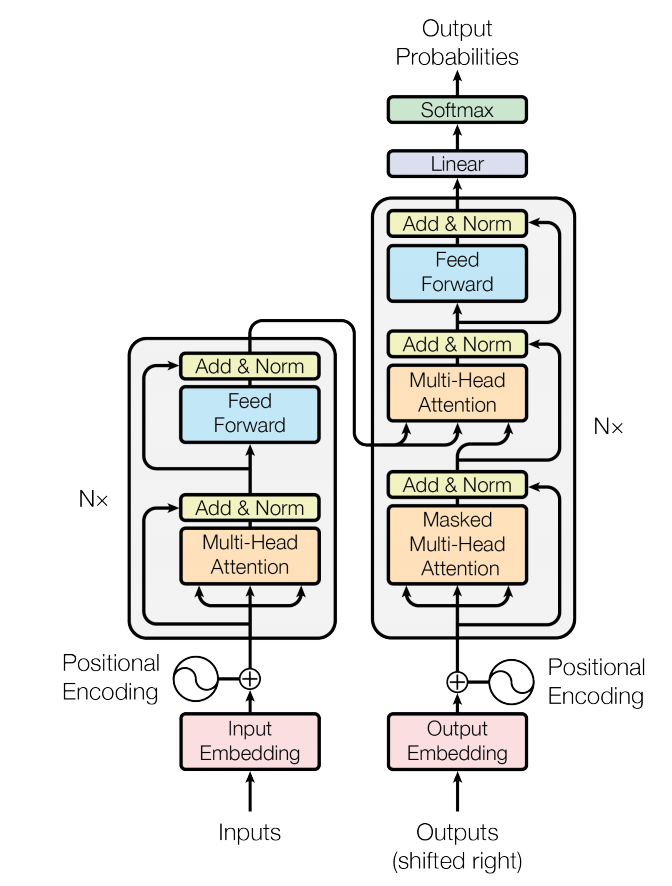</body></html>

<img src = "images/fulltransformer.png" width="300" height="600">

Start by loading in the model. We copy the checkpoint to local dir for speed, otherwise initialization takes a very long time. Last week you implemented the decoder part for the transformer. Now you will implement the encoder part. Concretely you will implement the following. 


<img src = "images/encoder.png" width="300" height="600">



<a name='2.1'></a>
### 2.1 Transformer Encoder

You will now implement the transformer encoder. Concretely you will implement two functions. The first function is `FeedForwardBlock`.

<a name='2.1.1'></a>
#### 2.1.1 The Feedforward Block

The `FeedForwardBlock` function is an important one so you will start by implementing it. To do so, you need to return a list of the following: 

- [`tl.LayerNorm()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.normalization.LayerNorm) = layer normalization.
- [`tl.Dense(d_ff)`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) = fully connected layer.
- [`activation`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.activation_fns.Relu) = activation relu, tanh, sigmoid etc. 
- `dropout_middle` = we gave you this function (don't worry about its implementation).
- [`tl.Dense(d_model)`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) = fully connected layer with same dimension as the model.
- `dropout_final` = we gave you this function (don't worry about its implementation).

You can always take a look at [trax documentation](https://trax-ml.readthedocs.io/en/latest/) if needed.

**Instructions**: Implement the feedforward part of the transformer. You will be returning a list. 

<a name='ex02'></a>
### Exercise 02

In [21]:
# GRADED FUNCTION: FeedForwardBlock
def FeedForwardBlock(d_model, d_ff, dropout, dropout_shared_axes, mode, activation):
    """Returns a list of layers implementing a feed-forward block.
    Args:
        d_model: int:  depth of embedding
        d_ff: int: depth of feed-forward layer
        dropout: float: dropout rate (how much to drop out)
        dropout_shared_axes: list of integers, axes to share dropout mask
        mode: str: 'train' or 'eval'
        activation: the non-linearity in feed-forward layer
    Returns:
        A list of layers which maps vectors to vectors.
    """
    
    dropout_middle = tl.Dropout(rate=dropout,
                                shared_axes=dropout_shared_axes, 
                                mode=mode)
  
    dropout_final = tl.Dropout(rate=dropout, 
                               shared_axes=dropout_shared_axes, 
                               mode=mode)

    ### START CODE HERE ###
    
    ff_block = [ 
        # trax Layer normalization 
        tl.LayerNorm(),
        # trax Dense layer using `d_ff`
        tl.Dense(d_ff),
        # activation() layer - you need to call (use parentheses) this func!
        activation(),
        # dropout middle layer
        dropout_middle,
        # trax Dense layer using `d_model`
        tl.Dense(d_model),
        # dropout final layer
        dropout_final,
    ]
    
    ### END CODE HERE ###
    
    return ff_block

In [22]:
# Print the block layout
feed_forward_example = FeedForwardBlock(d_model=512, d_ff=2048, dropout=0.8, dropout_shared_axes=0, mode = 'train', activation = tl.Relu)
print(feed_forward_example)

[LayerNorm, Dense_2048, Serial[
  Relu
], Dropout, Dense_512, Dropout]


#### **Expected Output:**
```CPP
 [LayerNorm, Dense_2048, Serial[
  Relu
 ], Dropout, Dense_512, Dropout]
```

In [23]:
FeedForwardBlock(d_model=16, d_ff=64, dropout=0.1, dropout_shared_axes=0, mode = 'train', activation = tl.Relu)

[LayerNorm,
 Dense_64,
 Serial[
   Relu
 ],
 Dropout,
 Dense_16,
 Dropout]

In [24]:
test_func = lambda x: list((map(type, x)))
test_func(FeedForwardBlock(d_model=16, d_ff=64, dropout=0.1, dropout_shared_axes=0, mode = 'train', activation = tl.Relu))

[trax.layers.normalization.LayerNorm,
 trax.layers.core.Dense,
 trax.layers.combinators.Serial,
 trax.layers.core.Dropout,
 trax.layers.core.Dense,
 trax.layers.core.Dropout]

In [25]:
# UNIT TEST
# test tokenize_and_mask
w3_tests.test_FeedForwardBlock(FeedForwardBlock)

 All tests passed


<a name='2.1.2'></a>
#### 2.1.2 The Encoder Block

The encoder block will use the `FeedForwardBlock`. 

You will have to build two residual connections. Inside the first residual connection you will have the `tl.LayerNorm()`, `attention`, and `dropout_` layers. The second residual connection will have the `feed_forward`.  

You will also need to implement `feed_forward`, `attention` and `dropout_` blocks. 

So far you haven't seen the [`tl.Attention()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.Attention) and [`tl.Residual()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Residual) layers so you can check the docs by clicking on them.

<a name='ex03'></a>
### Exercise 03

In [42]:
# GRADED FUNCTION: EncoderBlock
def EncoderBlock(d_model, d_ff, n_heads, dropout, dropout_shared_axes,
                  mode, ff_activation, FeedForwardBlock=FeedForwardBlock):
    """
    Returns a list of layers that implements a Transformer encoder block.
    The input to the layer is a pair, (activations, mask), where the mask was
    created from the original source tokens to prevent attending to the padding
    part of the input.
    
    Args:
        d_model (int): depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        dropout_shared_axes (int): axes on which to share dropout mask.
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.
        FeedForwardBlock (function): A function that returns the feed forward block.
    Returns:
        list: A list of layers that maps (activations, mask) to (activations, mask).
        
    """
    
    ### START CODE HERE ###
    
    # Attention block
    attention = tl.Attention( 
        # Use dimension of the model
        d_feature=d_model,
        # Set it equal to number of attention heads
        n_heads=n_heads,
        # Set it equal `dropout`
        dropout=dropout,
        # Set it equal `mode`
        mode=mode
    )
    
    # Call the function `FeedForwardBlock` (implemented before) and pass in the parameters
    feed_forward = FeedForwardBlock( 
        d_model=d_model,
        d_ff=d_ff,
        dropout=dropout,
        dropout_shared_axes=dropout_shared_axes,
        mode = mode,
        activation = ff_activation
    )
    
    # Dropout block
    dropout_ = tl.Dropout( 
        # set it equal to `dropout`
        rate=dropout,
        # set it equal to the axes on which to share dropout mask
        shared_axes=dropout_shared_axes,
        # set it equal to `mode`
        mode=mode
    )
    
    encoder_block = [ 
        # add `Residual` layer
        tl.Residual(
            # add norm layer
            tl.LayerNorm(),
            # add attention
            attention,
            # add dropout
            dropout_,
        ),
        # add another `Residual` layer
        tl.Residual(
            # add feed forward
            feed_forward,
        ),
    ]
    
    ### END CODE HERE ###
    
    return encoder_block

In [43]:
# Print the block layout
encoder_example = EncoderBlock(d_model=512, d_ff=2048, n_heads=6, dropout=0.8, dropout_shared_axes=0, mode = 'train', ff_activation=tl.Relu)
print(encoder_example)

[Serial_in2_out2[
  Branch_in2_out3[
    None
    Serial_in2_out2[
      LayerNorm
      Serial_in2_out2[
        _in2_out2
        Serial_in2_out2[
          Select[0,0,0]_out3
          Serial_in4_out2[
            _in4_out4
            Serial_in4_out2[
              Parallel_in3_out3[
                Dense_512
                Dense_512
                Dense_512
              ]
              PureAttention_in4_out2
              Dense_512
            ]
            _in2_out2
          ]
        ]
        _in2_out2
      ]
      Dropout
    ]
  ]
  Add_in2
], Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Dense_2048
      Serial[
        Relu
      ]
      Dropout
      Dense_512
      Dropout
    ]
  ]
  Add_in2
]]


#### **Expected Output:**
```CPP
[Serial_in2_out2[
  Branch_in2_out3[
    None
    Serial_in2_out2[
      LayerNorm
      Serial_in2_out2[
        _in2_out2
        Serial_in2_out2[
          Select[0,0,0]_out3
          Serial_in4_out2[
            _in4_out4
            Serial_in4_out2[
              Parallel_in3_out3[
                Dense_512
                Dense_512
                Dense_512
              ]
              PureAttention_in4_out2
              Dense_512
            ]
            _in2_out2
          ]
        ]
        _in2_out2
      ]
      Dropout
    ]
  ]
  Add_in2
], Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Dense_2048
      Serial[
        Relu
      ]
      Dropout
      Dense_512
      Dropout
    ]
  ]
  Add_in2
]]
```

In [45]:
# UNIT TEST
# test EncoderBlock
w3_tests.test_EncoderBlock(EncoderBlock)

 All tests passed


<a name='2.1.3'></a>
### 2.1.3 The Transformer Encoder

Now that you have implemented the `EncoderBlock`, it is time to build the full encoder. BERT, or Bidirectional Encoder Representations from Transformers is one such encoder. 

You will implement its core code in the function below by using the functions you have coded so far. 

The model takes in many hyperparameters, such as the `vocab_size`, the number of classes, the dimension of your model, etc. You want to build a generic function that will take in many parameters, so you can use it later. At the end of the day, anyone can just load in an API and call transformer, but we think it is important to make sure you understand how it is built. Let's get started. 

**Instructions:** For this encoder you will need a `positional_encoder` first (which is already provided) followed by `n_layers` encoder blocks, which are the same encoder blocks you previously built. Once you store the `n_layers` `EncoderBlock` in a list, you are going to encode a `Serial` layer with the following sublayers: 

- [`tl.Branch`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Branch): helps with the branching and has the following sublayers:
    - `positional_encoder`.
    - [`tl.PaddingMask()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.PaddingMask): layer that maps integer sequences to padding masks.
- Your list of `EncoderBlock`s
- [`tl.Select([0], n_in=2)`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Select):  Copies, reorders, or deletes stack elements according to indices.
- [`tl.LayerNorm()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.normalization.LayerNorm).
- [`tl.Mean()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Mean): Mean along the first axis.
- `tl.Dense()` with n_units set to n_classes. 
- `tl.LogSoftmax()`   

Please refer to the [trax documentation](https://trax-ml.readthedocs.io/en/latest/) for further information. 

<a name='ex04'></a>
### Exercise 04

In [46]:
# GRADED FUNCTION: TransformerEncoder
def TransformerEncoder(vocab_size=32000,
                       n_classes=10,
                       d_model=512,
                       d_ff=2048,
                       n_layers=6,
                       n_heads=8,
                       dropout=0.1,
                       dropout_shared_axes=None,
                       max_len=2048,
                       mode='train',
                       ff_activation=tl.Relu,
                      EncoderBlock=EncoderBlock):
    
    """
    Returns a Transformer encoder model.
    The input to the model is a tensor of tokens.
  
    Args:
        vocab_size (int): vocab size. Defaults to vocab_size.
        n_classes (int): how many classes on output. Defaults to 10.
        d_model (int): depth of embedding. Defaults to 512.
        d_ff (int): depth of feed-forward layer. Defaults to 2048.
        n_layers (int): number of encoder/decoder layers. Defaults to 6.
        n_heads (int): number of attention heads. Defaults to 8.
        dropout (float): dropout rate (how much to drop out). Defaults to 0.1.
        dropout_shared_axes (int): axes on which to share dropout mask. Defaults to None.
        max_len (int): maximum symbol length for positional encoding. Defaults to 2048.
        mode (str): 'train' or 'eval'. Defaults to 'train'.
        ff_activation (function): the non-linearity in feed-forward layer. Defaults to tl.Relu.
        EncoderBlock (function): Returns the encoder block. Defaults to EncoderBlock.
  
    Returns:
        trax.layers.combinators.Serial: A Transformer model as a layer that maps
        from a tensor of tokens to activations over a set of output classes.
    """
    
    positional_encoder = [
        tl.Embedding(vocab_size, d_model),
        tl.Dropout(rate=dropout, shared_axes=dropout_shared_axes, mode=mode),
        tl.PositionalEncoding(max_len=max_len)
    ]
    
    ### START CODE HERE ###
    
    # Use the function `EncoderBlock` (implemented above) and pass in the parameters over `n_layers`
    encoder_blocks=[EncoderBlock(d_model, d_ff, n_heads, dropout, dropout_shared_axes, mode, ff_activation) for _ in range(n_layers)]

    # Assemble and return the model.
    return tl.Serial(
        # Encode
        tl.Branch(
            # Use `positional_encoder`
            positional_encoder,
            # Use trax padding mask
            tl.PaddingMask()
        ),
        # Use `encoder_blocks`
        encoder_blocks,
        # Use select layer
        tl.Select([0], n_in=2),
        # Use trax layer normalization
        tl.LayerNorm(),
        # Map to output categories.
        # Use trax mean. set axis to 1
        tl.Mean(axis=1),
        # Use trax Dense using `n_classes`
        tl.Dense(n_classes),
        # Use trax log softmax
        tl.LogSoftmax()
    )

    ### END CODE HERE ###

In [47]:
# Run this cell to see the structure of your model
# Only 1 layer is used to keep the output readable
TransformerEncoder(n_layers=1)

Serial[
  Branch_out2[
    [Embedding_32000_512, Dropout, PositionalEncoding]
    Serial[
      PaddingMask(0)
    ]
  ]
  Serial_in2_out2[
    Branch_in2_out3[
      None
      Serial_in2_out2[
        LayerNorm
        Serial_in2_out2[
          _in2_out2
          Serial_in2_out2[
            Select[0,0,0]_out3
            Serial_in4_out2[
              _in4_out4
              Serial_in4_out2[
                Parallel_in3_out3[
                  Dense_512
                  Dense_512
                  Dense_512
                ]
                PureAttention_in4_out2
                Dense_512
              ]
              _in2_out2
            ]
          ]
          _in2_out2
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  Select[0]_in2
  LayerNorm
  Mean
  Dense_10


#### **Expected Output:**
```CPP
Serial[
  Branch_out2[
    [Embedding_32000_512, Dropout, PositionalEncoding]
    Serial[
      PaddingMask(0)
    ]
  ]
  Serial_in2_out2[
    Branch_in2_out3[
      None
      Serial_in2_out2[
        LayerNorm
        Serial_in2_out2[
          _in2_out2
          Serial_in2_out2[
            Select[0,0,0]_out3
            Serial_in4_out2[
              _in4_out4
              Serial_in4_out2[
                Parallel_in3_out3[
                  Dense_512
                  Dense_512
                  Dense_512
                ]
                PureAttention_in4_out2
                Dense_512
              ]
              _in2_out2
            ]
          ]
          _in2_out2
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  Select[0]_in2
  LayerNorm
  Mean
  Dense_10
  LogSoftmax
]
```

In [48]:
# UNIT TEST
# test TransformerEncoder
w3_tests.test_TransformerEncoder(TransformerEncoder)

 All tests passed


**NOTE Congratulations! You have completed all of the graded functions of this assignment.** Since the rest of the assignment takes a lot of time and memory to run we are providing some extra ungraded labs for you to see this model in action.

**Keep it up!**